EDB

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import PowerTransformer, RobustScaler, QuantileTransformer, StandardScaler

import pydotplus
from graphviz import Source
from IPython.display import Image, display
import graphviz

from scipy import stats
from scipy.stats import mstats


In [2]:
train_data = np.load('fashion_train.npy')
test_data = np.load('fashion_test.npy')

In [3]:
# Seperating the labels
train_labels = train_data[:, -1]
test_labels = test_data[:, -1]

In [4]:
# Dropping labels from data
train_data = train_data[:, :-1]
test_data = test_data[:, :-1]

In [5]:
# Check for NaN values in the dataset
print(f"NaN values in train_data: {np.isnan(train_data).sum()}")
print(f"NaN values in test_data: {np.isnan(test_data).sum()}")

NaN values in train_data: 0
NaN values in test_data: 0


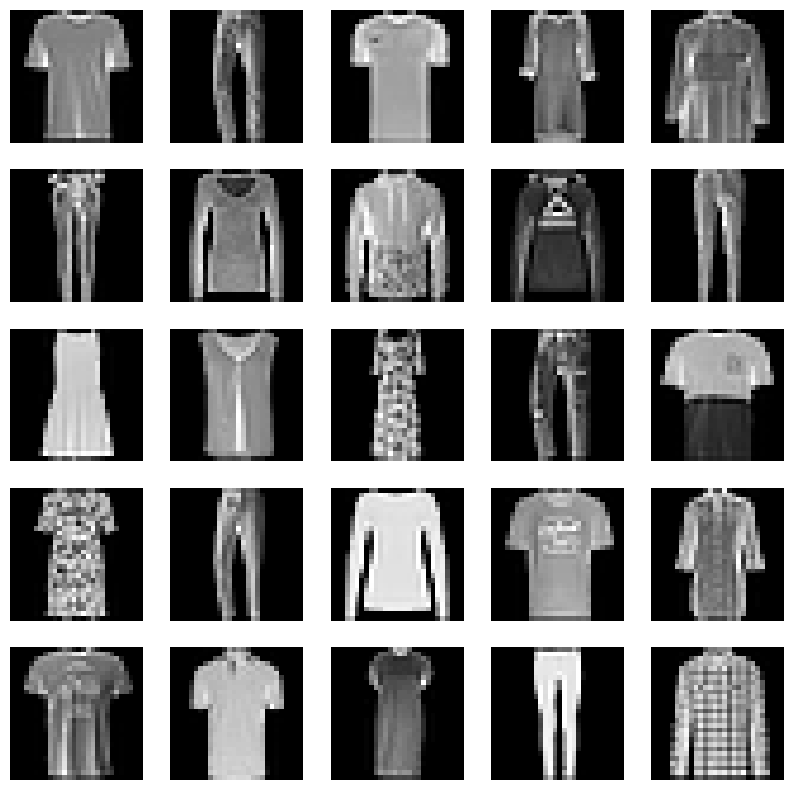

In [6]:
#Convert images to grayscale 28X28
import numpy as np

# Reshape the data to 28x28 images
train_gray = train_data.reshape(-1, 28, 28)
test_gray = test_data.reshape(-1, 28, 28)

# Plot a few sample images to verify
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_gray[i], cmap='gray')
    plt.axis('off')
plt.show()


In [7]:
colors = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green', 4: 'purple'}
label_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}

In [8]:
# Count the occurrences of each label
unique, counts = np.unique(train_labels, return_counts=True)

In [9]:
# Map the colors and label names to the unique labels
pie_colors = [colors[label] for label in unique]
pie_labels = [label_names[label] for label in unique]

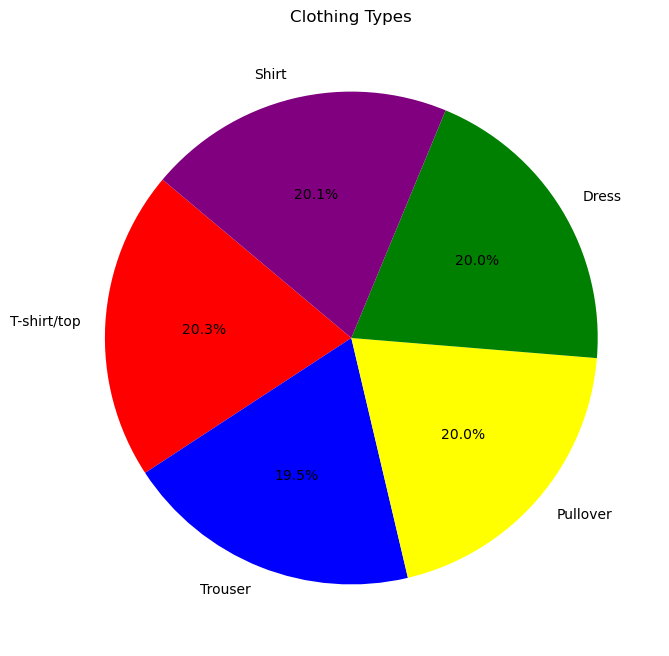

In [10]:
# Create a pie chart of normalized pixel values for each category
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%', startangle=140)
plt.title('Clothing Types')
plt.show()

This pie chart shows that we have a nearly equally balanced dataset, meaning that the risk of bias is reduced.

In [11]:
# Function to calculate the number of bins using Scott's rule
def scott_bins(data):
    std_dev = np.std(data)
    bin_width = 3.5 * std_dev * len(data) ** (-1/3)
    bins = int((data.max() - data.min()) / bin_width)
    return bins

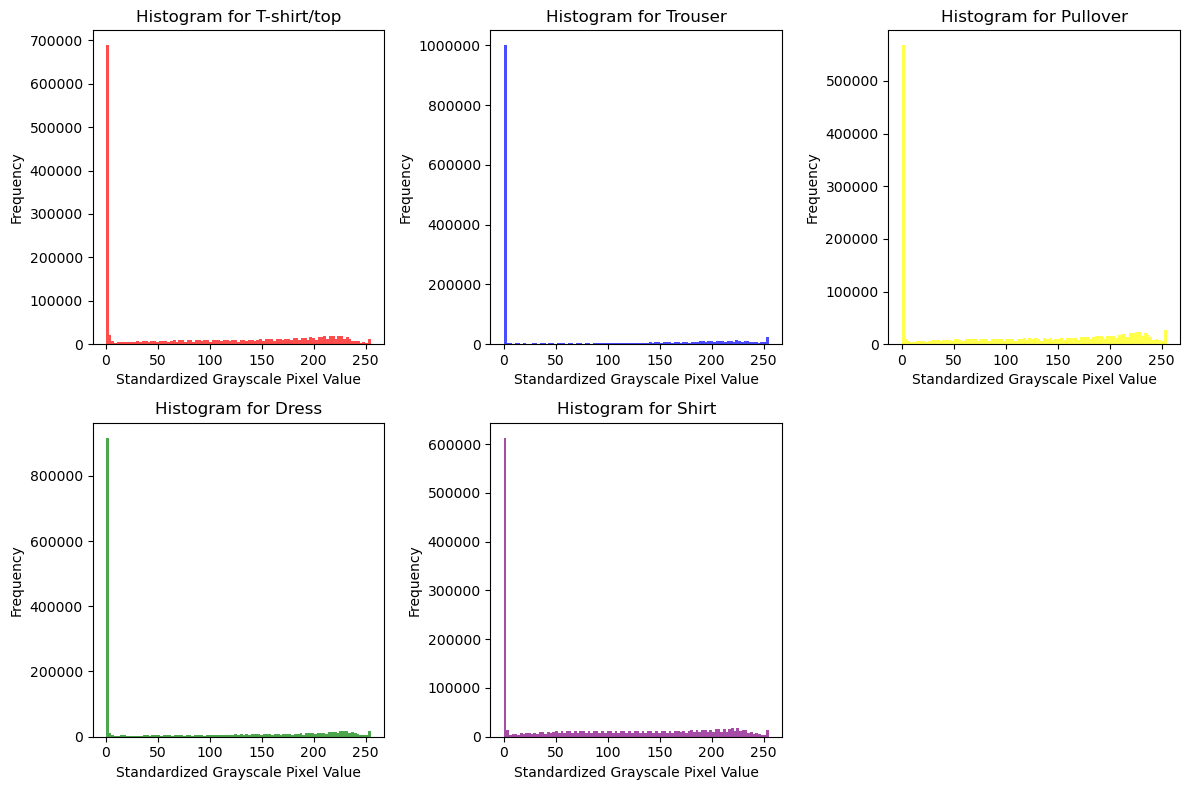

In [12]:
# Create a single chart with multiple histograms and limited axes
plt.figure(figsize=(12, 8))

for i, label in enumerate(np.unique(train_labels)):
    plt.subplot(2, 3, i + 1)
    data = train_gray[train_labels == label].flatten()
    bins = scott_bins(data)
    plt.hist(data, bins=bins, color=colors[label], alpha=0.7)
    plt.title(f'Histogram for {label_names[label]}')
    plt.xlabel('Standardized Grayscale Pixel Value')
    plt.ylabel('Frequency')
    plt.ticklabel_format(style='plain', axis='y')  # Display y-axis in plain format

plt.tight_layout()
plt.show()


running the scaler on the grayscale images makes sense, as it will help standardize the pixel values across the entire dataset. This will ensure that each pixel value has a mean of 0 and a standard deviation of 1, making the data more suitable for PCA.

In [13]:
# Reshape the grayscale images to a 2D array (flattened)
train_gray_flattened = train_gray.reshape(train_gray.shape[0], -1)
test_gray_flattened = test_gray.reshape(test_gray.shape[0], -1)

# Standardize the grayscale images
scaler = StandardScaler()
train_gray_standardized = scaler.fit_transform(train_gray_flattened)
test_gray_standardized = scaler.transform(test_gray_flattened)

# Reshape back to 28x28 images
train_gray_standardized = train_gray_standardized.reshape(train_gray.shape)
test_gray_standardized = test_gray_standardized.reshape(test_gray.shape)


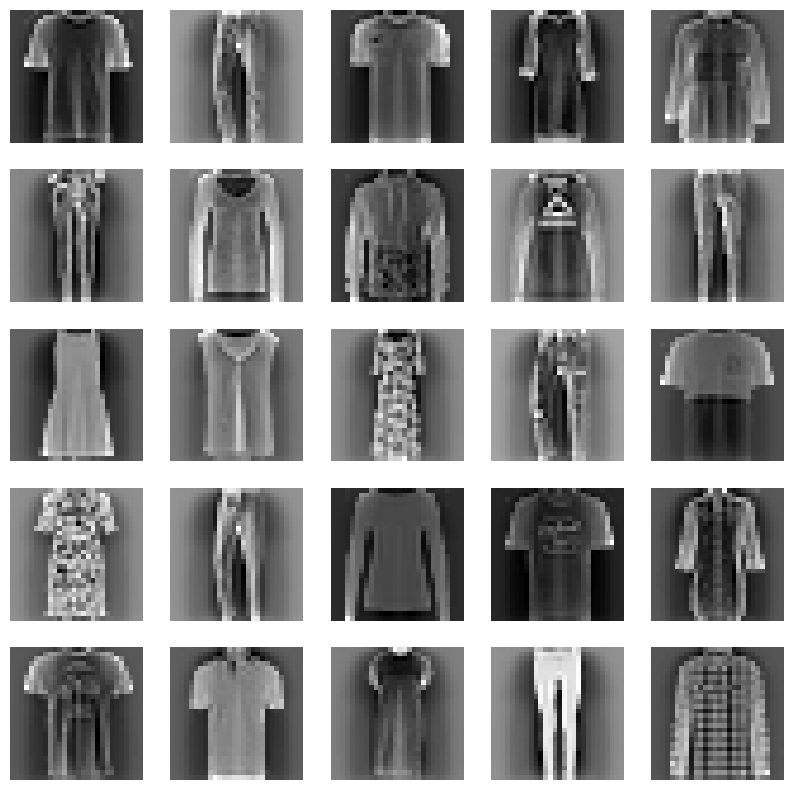

In [14]:
# Plot a few sample images to verify
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_gray_standardized[i], cmap='gray')
    plt.axis('off')
plt.show()


Scaling doesn't lose data because it only changes the range of the data, not the actual values or their relationships. Here's why:

Preservation of Relationships: Scaling adjusts the range of the data but maintains the relative distances between data points. This means that the patterns and relationships in the data remain intact.

Normalization: When you normalize data, you adjust the values to a common scale, typically between 0 and 1 or -1 and 1. This helps in comparing different features without altering the underlying information.

Standardization: Standardizing data involves subtracting the mean and dividing by the standard deviation. This transforms the data to have a mean of 0 and a standard deviation of 1, making it easier to work with algorithms that assume normally distributed data.

Improved Algorithm Performance: Many machine learning algorithms perform better with scaled data because it ensures that all features contribute equally to the model. This can lead to faster convergence and more accurate results.

In essence, scaling is a preprocessing step that enhances the usability of the data without altering its inherent structure or losing any information. It's like resizing a photo: the image remains the same, but the dimensions are adjusted for better fit and clarity.

Scott's rule is a method for determining the optimal number of bins to use when creating a histogram. It aims to balance the trade-off between having too many bins (which can make the histogram noisy) and too few bins (which can obscure important details). The rule is defined as follows:

Bin width
=
3.5
×
𝜎
𝑛
1
/
3
Where:

𝜎
 is the standard deviation of the data.

𝑛
 is the number of data points.

The number of bins is then calculated by dividing the range of the data by the bin width.

Why We're Using Scott's Rule Here

Balance Between Detail and Noise: Scott's rule helps in finding a balance between having too many bins, which can make the histogram appear noisy, and too few bins, which can obscure important details. This is particularly useful for our dataset, where we want to capture the distribution of pixel values without losing important information.

Adaptability: Scott's rule adapts to the variability in the data. Since it takes into account the standard deviation, it adjusts the bin width based on the spread of the data. This makes it suitable for datasets with varying levels of variability, like ours.

Simplicity: The formula is straightforward and easy to implement. It provides a quick and effective way to determine the number of bins, making it a practical choice for our analysis.

Consistency: Using a standardized method like Scott's rule ensures consistency in our histograms, allowing for easier comparison between different categories in our dataset.

In summary, Scott's rule provides a balanced, adaptable, and straightforward approach to determining the number of bins for our histograms, making it an ideal choice for visualizing the distribution of pixel values in our dataset.

In [15]:
# Function to calculate the number of bins using Scott's rule
def scott_bins(data):
    std_dev = np.std(data)
    bin_width = 3.5 * std_dev * len(data) ** (-1 / 3)
    bins = int((data.max() - data.min()) / bin_width)
    return bins

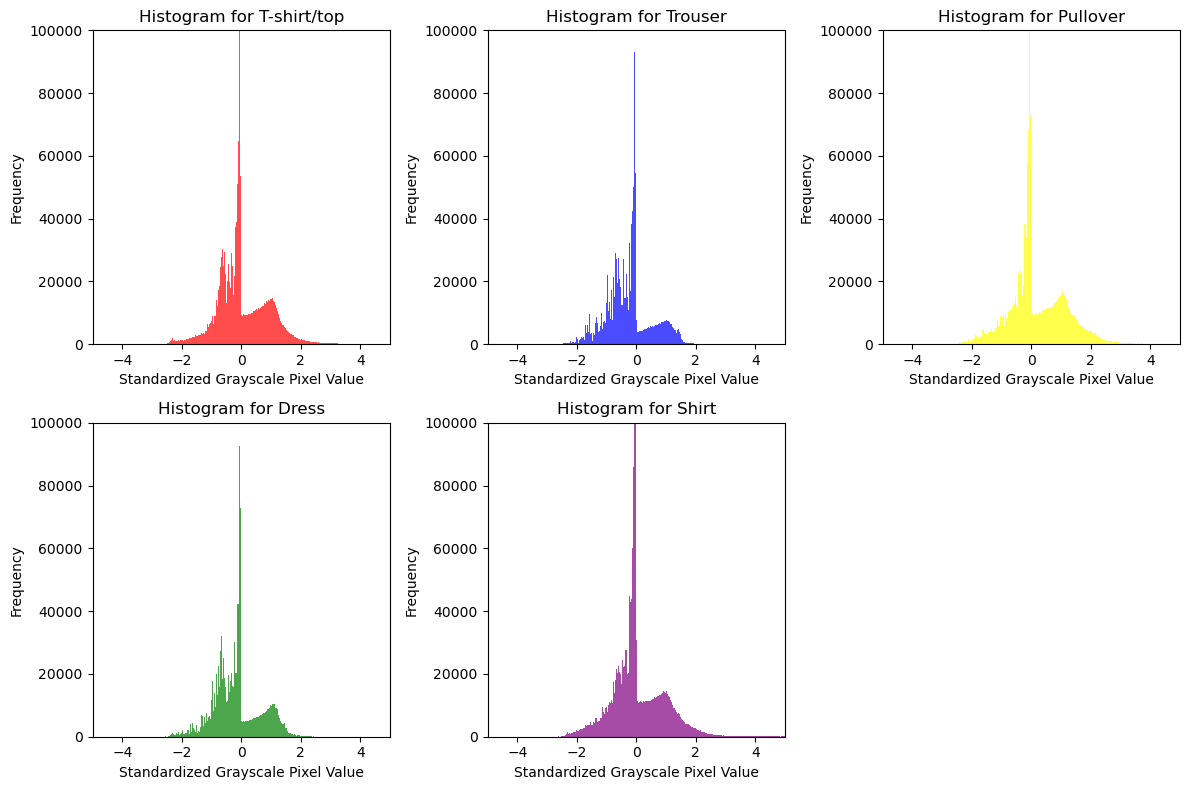

In [16]:
# Create a single chart with multiple histograms and limited axes
plt.figure(figsize=(12, 8))

for i, label in enumerate(np.unique(train_labels)):
    plt.subplot(2, 3, i + 1)
    data = train_gray_standardized[train_labels == label].flatten()
    bins = scott_bins(data)
    plt.hist(data, bins=bins, color=colors[label], alpha=0.7)
    plt.xlim(-5, 5)  # Set x-axis limits to -5 to 5
    plt.ylim(0, 100000)  # Set y-axis limits to 0 to 100,000
    plt.title(f'Histogram for {label_names[label]}')
    plt.xlabel('Standardized Grayscale Pixel Value')
    plt.ylabel('Frequency')
    plt.ticklabel_format(style='plain', axis='y')  # Display y-axis in plain format

plt.tight_layout()
plt.show()


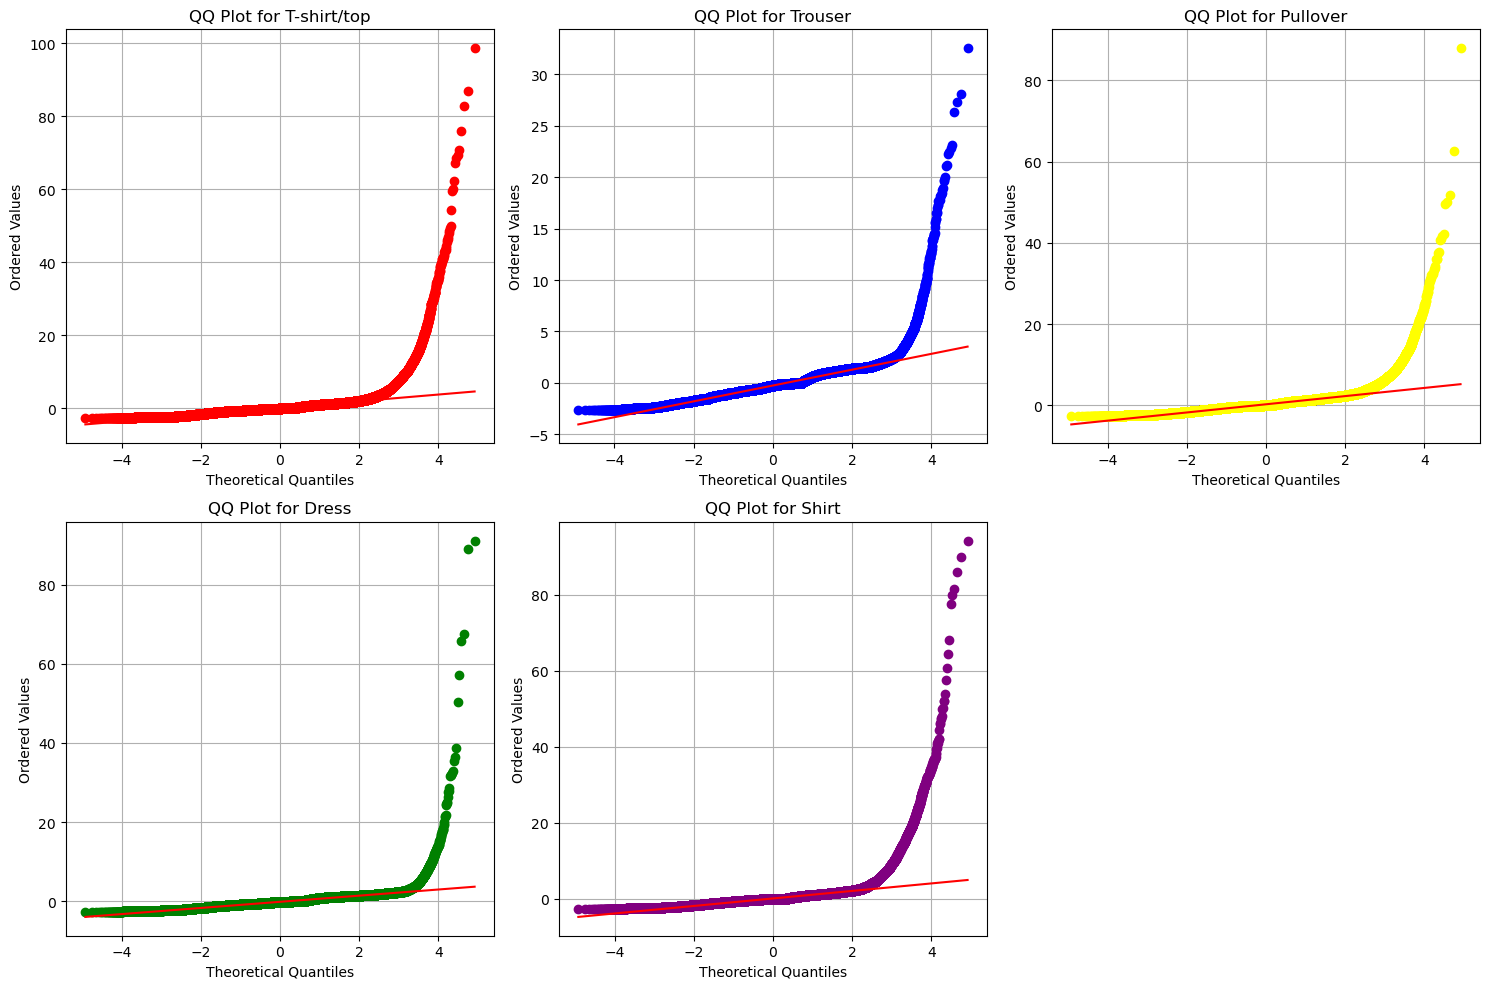

In [17]:
# Create a single chart with multiple QQ plots
plt.figure(figsize=(15, 10))

for i, label in enumerate(np.unique(train_labels)):
    plt.subplot(2, 3, i + 1)
    data = train_gray_standardized[train_labels == label].flatten()
    (osm, osr), (slope, intercept, r) = stats.probplot(data, dist="norm")
    plt.plot(osm, osr, 'o', color=colors[label])  # Color the points
    plt.plot(osm, slope * osm + intercept, 'r')  # Red line
    plt.title(f'QQ Plot for {label_names[label]}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')
    plt.grid(True)

plt.tight_layout()
plt.show()


Although both the histograms and the boxplots indicate that this is still not a perfect normal distribution, I have tried other methods and they all yielded a worse result. We must accept that real life data is imperfect and continue as best we can.

I believe that the limitation is simply in the amount of samples we have, which does not have enough values to approach a normal distribution under the law of large numbers. Bootstrapping could help with that, but that is beyond the scope of our plans for this assignment.

Since outliers are not usually an influence on decision trees, we have chosen to leave thim in for now. We might remove them before we create a neural network.

This should be a good enough transformation and distribution to continue with the Decision tree and Neural Network to come.

C:\Users\shano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


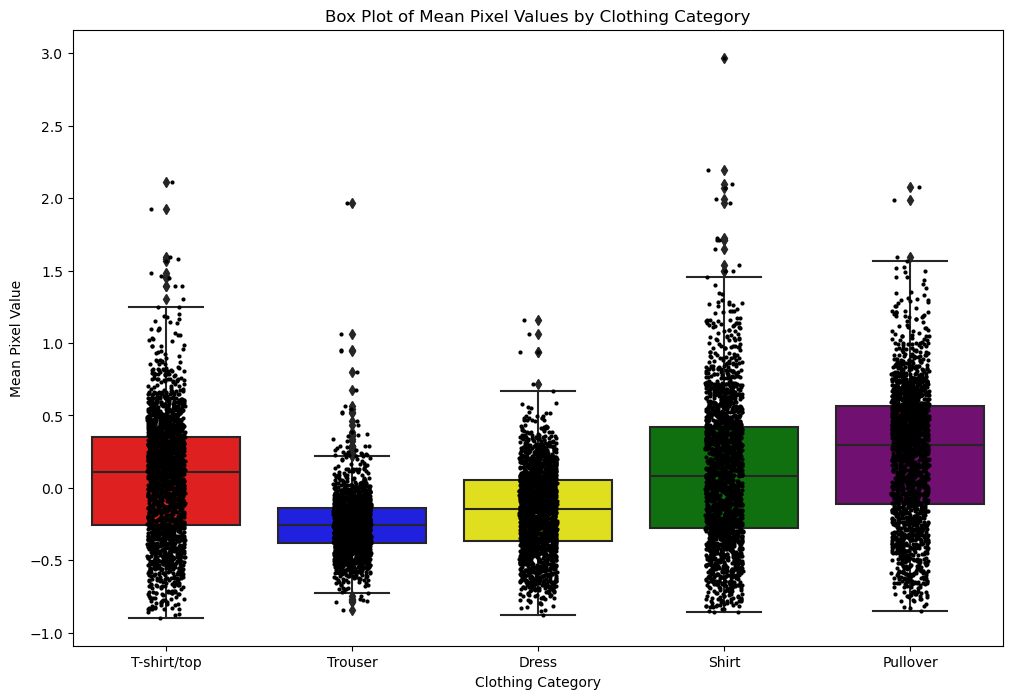

In [18]:
# Create a DataFrame for Seaborn
df = pd.DataFrame({'Category': train_labels, 'Mean Pixel Value': train_gray_standardized.mean(axis=(1, 2))})

# Map the label names to the unique labels
df['Category'] = df['Category'].map({0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'})

# Create a box plot with Seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x='Category', y='Mean Pixel Value', data=df, palette=['red', 'blue', 'yellow', 'green', 'purple'])

# Add points for individual data points using stripplot
sns.stripplot(x='Category', y='Mean Pixel Value', data=df, color='black', size=3, jitter=True)

# Show the plot
plt.title('Box Plot of Mean Pixel Values by Clothing Category')
plt.xlabel('Clothing Category')
plt.ylabel('Mean Pixel Value')
plt.show()


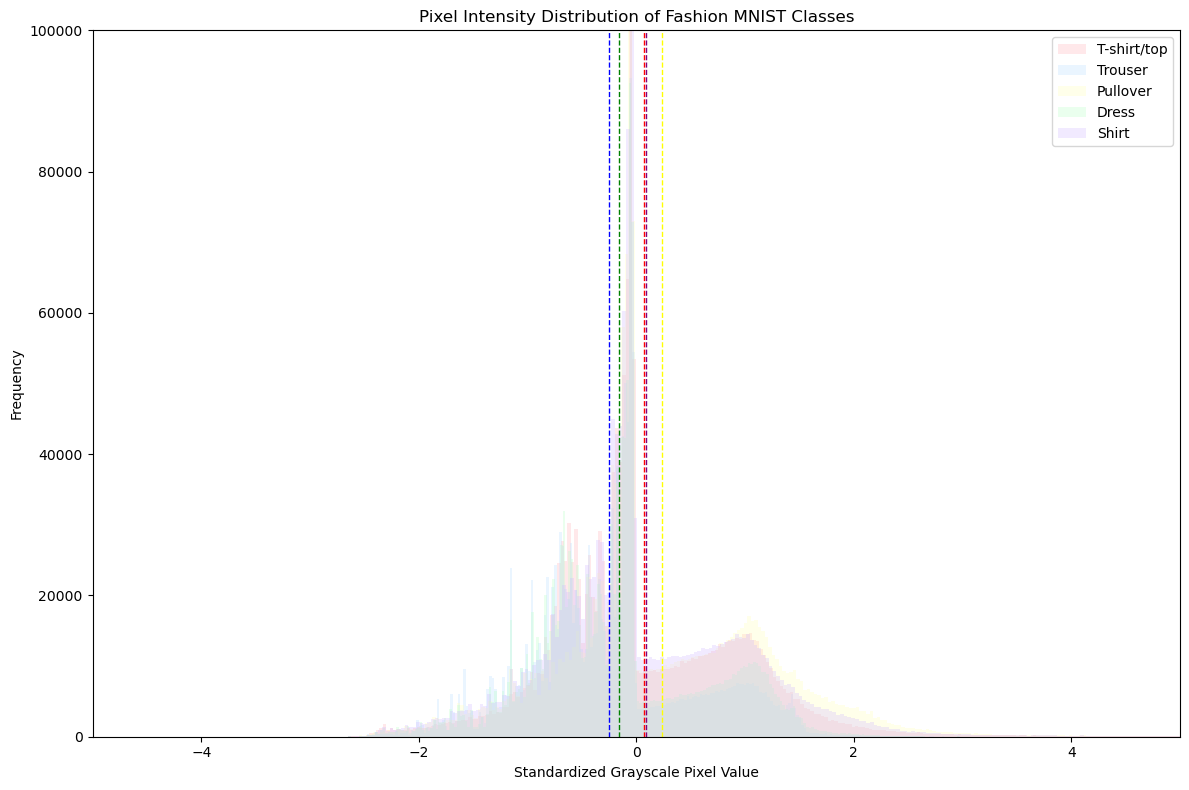

In [19]:
# Create a single chart with multiple histograms and limited axes
plt.figure(figsize=(12, 8))

# T-shirt/top
data = train_gray_standardized[train_labels == 0].flatten()
bins = scott_bins(data)
plt.hist(data, bins=bins, color='#FFB3BA', alpha=0.3, label='T-shirt/top')
plt.axvline(np.mean(data), color='red', linestyle='dashed', linewidth=1)

# Trouser
data = train_gray_standardized[train_labels == 1].flatten()
bins = scott_bins(data)
plt.hist(data, bins=bins, color='#BAE1FF', alpha=0.3, label='Trouser')
plt.axvline(np.mean(data), color='blue', linestyle='dashed', linewidth=1)

# Pullover
data = train_gray_standardized[train_labels == 2].flatten()
bins = scott_bins(data)
plt.hist(data, bins=bins, color='#FFFFBA', alpha=0.3, label='Pullover')
plt.axvline(np.mean(data), color='yellow', linestyle='dashed', linewidth=1)

# Dress
data = train_gray_standardized[train_labels == 3].flatten()
bins = scott_bins(data)
plt.hist(data, bins=bins, color='#BAFFC9', alpha=0.3, label='Dress')
plt.axvline(np.mean(data), color='green', linestyle='dashed', linewidth=1)

# Shirt
data = train_gray_standardized[train_labels == 4].flatten()
bins = scott_bins(data)
plt.hist(data, bins=bins, color='#D1BAFF', alpha=0.3, label='Shirt')
plt.axvline(np.mean(data), color='purple', linestyle='dashed', linewidth=1)

plt.legend()
plt.xlabel('Standardized Grayscale Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution of Fashion MNIST Classes')
plt.xlim(-5, 5)  # Set x-axis limits to -5 to 5
plt.ylim(0, 100000)  # Set y-axis limits to 0 to 100,000
plt.ticklabel_format(style='plain', axis='y')  # Display y-axis in plain format
plt.tight_layout()
plt.show()


Now that we have as close to a standard, normal distribution as possible, we can start our Primary Component Analysis using the transformed data.

Normalizing and standardizing data before performing Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA) is crucial for several reasons:

Equal Contribution of Features: Standardization ensures that each feature contributes equally to the analysis. Without standardization, features with larger scales could dominate the principal components, leading to biased results.

Improved Algorithm Performance: Many machine learning algorithms, including PCA and LDA, perform better with scaled data. Standardization helps in achieving faster convergence and more accurate results.

Handling Different Units: When features are measured in different units, standardization brings them to a common scale, making the analysis more meaningful and comparable.

Variance-Based Importance: PCA assumes that the importance of a feature is determined by its variance. Standardization aligns with this assumption by ensuring that each feature's contribution is based on a standardized scale, where variability is expressed in terms of standard deviation.



In [20]:
# Check for NaN values in the dataset
print(f"NaN values in train_data: {np.isnan(train_gray_standardized).sum()}")
print(f"NaN values in test_data: {np.isnan(test_gray_standardized).sum()}")

NaN values in train_data: 0
NaN values in test_data: 0


Principle Component Analysis

Principal Component Analysis (PCA) is used in to reduce the dimensionality of large datasets while preserving as much variability as possible. Here's a breakdown of how it works:

1. Standardize the Data: First, we standardize the data to have a mean of zero and a standard deviation of one. This ensures that each feature contributes equally to the analysis.

2. Compute the Covariance Matrix: Next, we calculate the covariance matrix of the standardized data. This matrix shows the relationships between different features in the dataset.

3. Find Eigenvalues and Eigenvectors: We then find the eigenvalues and eigenvectors of the covariance matrix. The eigenvectors represent the directions of maximum variance, while the eigenvalues indicate the magnitude of this variance.

4. Select Principal Components: The eigenvectors are sorted in descending order based on their corresponding eigenvalues. We select the top eigenvectors (principal components) to form a new feature space. The number of principal components chosen depends on how much dimensionality reduction we want.

5. Transform the Data: Finally, we project the original data onto the new feature space defined by the principal components. This results in a transformed dataset with reduced dimensions.

PCA is useful for tasks like data visualization, noise reduction, and feature extraction. By reducing the number of dimensions, it helps simplify complex datasets and improve the performance of machine learning algorithms.

In [21]:
# Define the number of components to keep
n_components = 4

# Reshape the grayscale images to a 2D array (flattened)
train_gray_flattened = train_gray_standardized.reshape(train_gray_standardized.shape[0], -1)
test_gray_flattened = test_gray_standardized.reshape(test_gray_standardized.shape[0], -1)

# Make PCA model
pca = PCA(n_components=n_components)

# Fit PCA on the training data and transform both training and test data
train_data_pca = pca.fit_transform(train_gray_flattened)
test_data_pca = pca.transform(test_gray_flattened)

print(f"Original shape: {train_gray_flattened.shape}")
print(f"Transformed shape: {train_data_pca.shape}")


Original shape: (10000, 784)
Transformed shape: (10000, 4)


The Explained Variance Ratio is used in Principal Component Analysis (PCA) to indicate how much of the total variance in the data is captured by each principal component. It tells us how much information each principal component retains from the original dataset. The higher the explained variance ratio, the more significant that principal component is in representing the data. This helps in deciding how many principal components to keep for dimensionality reduction.

In [22]:
# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance by the first four principal components: {explained_variance_ratio}")
# Calculate the total variance explained by the first two principal components
total_explained_variance = np.sum(explained_variance_ratio)
print(f"Total variance explained by the first four principal components: {total_explained_variance * 100:.2f}%")

Explained variance by the first four principal components: [0.22645698 0.13673557 0.06381166 0.05046707]
Total variance explained by the first four principal components: 47.75%


In [23]:
# Function to plot PCA results with specified colors and labels for each category
def plot_pca(data, labels, title):
    plt.figure(figsize=(10, 7))
    colors = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green', 4: 'purple'}
    label_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}
    
    for label in np.unique(labels):
        indices = labels == label
        plt.scatter(data[indices, 0], data[indices, 1], color=colors[label], label=label_names[label], alpha=0.5)
    
    plt.legend()
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

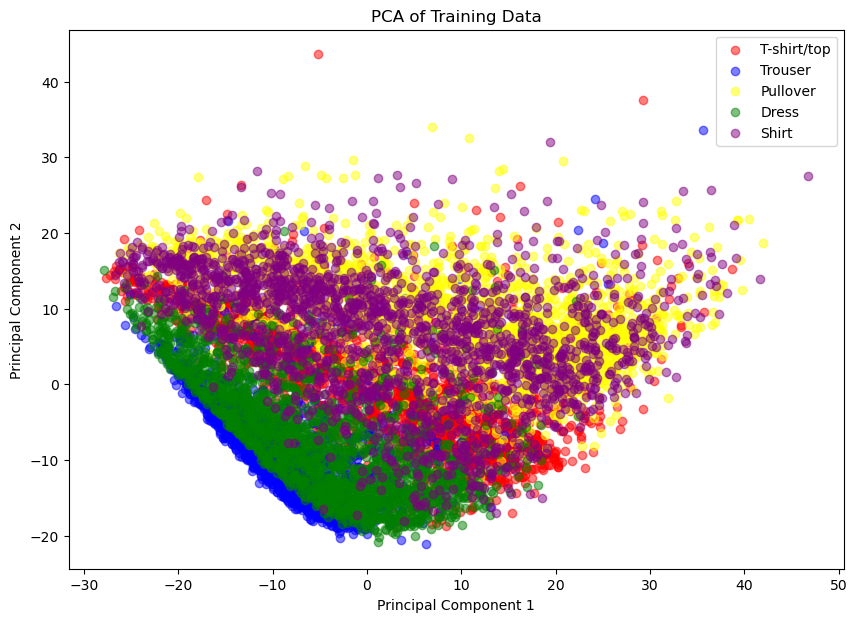

In [24]:
# Plotting the PCA results for the training data
plot_pca(train_data_pca, train_labels, 'PCA of Training Data')

Linear Discriminant Analysis (LDA) is used in to find a linear combination of features that best separates two or more classes of objects or events. It maximizes the separation between different classes by projecting the data onto a lower-dimensional space defined by the linear discriminants. This makes it particularly useful for classification tasks.

1. Standardize the Data: First, we standardize the data to have a mean of zero and a standard deviation of one. This ensures that each feature contributes equally to the analysis.

2. Compute the Mean Vectors: Next, we calculate the mean vectors for each class in the dataset. These vectors represent the average values for each feature within each class.

3. Compute the Scatter Matrices: We then compute the within-class scatter matrix and the between-class scatter matrix. The within-class scatter matrix measures the spread of data points within each class, while the between-class scatter matrix measures the spread of the mean vectors between classes.

4. Find Eigenvalues and Eigenvectors: We find the eigenvalues and eigenvectors of the matrix obtained by multiplying the inverse of the within-class scatter matrix by the between-class scatter matrix. The eigenvectors represent the directions that maximize the separation between classes, while the eigenvalues indicate the magnitude of this separation.

5. Select Linear Discriminants: The eigenvectors are sorted in descending order based on their corresponding eigenvalues. We select the top eigenvectors (linear discriminants) to form a new feature space. The number of linear discriminants chosen depends on the number of classes minus one.

6. Transform the Data: Finally, we project the original data onto the new feature space defined by the linear discriminants. This results in a transformed dataset with reduced dimensions.

LDA is useful for classification tasks, as it maximizes the separation between different classes. By reducing the number of dimensions, it helps to simplify complex datasets and improve the performance of machine learning algorithms.

In [25]:
# Reshape the grayscale images to a 2D array (flattened)
train_gray_flattened = train_gray_standardized.reshape(train_gray_standardized.shape[0], -1)
test_gray_flattened = test_gray_standardized.reshape(test_gray_standardized.shape[0], -1)

# Initialize LDA
lda = LinearDiscriminantAnalysis(n_components=4)

# Fit LDA on the training data and transform both training and test data
train_data_lda = lda.fit_transform(train_gray_flattened, train_labels)
test_data_lda = lda.transform(test_gray_flattened)

print(f"Original shape: {train_gray_flattened.shape}")
print(f"Transformed shape: {train_data_lda.shape}")


Original shape: (10000, 784)
Transformed shape: (10000, 4)


The Explained Variance Ratio is also used in Linear Discriminant Analysis (LDA). In LDA, it indicates how much of the total variance is captured by each linear discriminant. This helps in understanding the importance of each discriminant in separating the classes and deciding how many discriminants to keep for dimensionality reduction.

In [26]:
# Calculate the explained variance ratio
explained_variance_ratio_lda = lda.explained_variance_ratio_
print(f"Explained variance by the first four linear discriminants: {explained_variance_ratio_lda}")
# Calculate the total variance explained by the first four linear discriminants
total_explained_variance_lda = np.sum(explained_variance_ratio_lda)
print(f"Total variance explained by the first four linear discriminants: {total_explained_variance_lda * 100:.2f}%")

Explained variance by the first four linear discriminants: [0.61113178 0.20240552 0.13128745 0.05517525]
Total variance explained by the first four linear discriminants: 100.00%


In [27]:
# Define a function to plot LDA results with specified colors and labels for each category
def plot_lda(data, labels, title):
    plt.figure(figsize=(10, 7))
    colors = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green', 4: 'purple'}
    label_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}
    
    for label in np.unique(labels):
        indices = labels == label
        plt.scatter(data[indices, 0], data[indices, 1], color=colors[label], label=label_names[label], alpha=0.5)
    
    plt.legend()
    plt.title(title)
    plt.xlabel('Linear Discriminant 1')
    plt.ylabel('Linear Discriminant 2')
    plt.show()

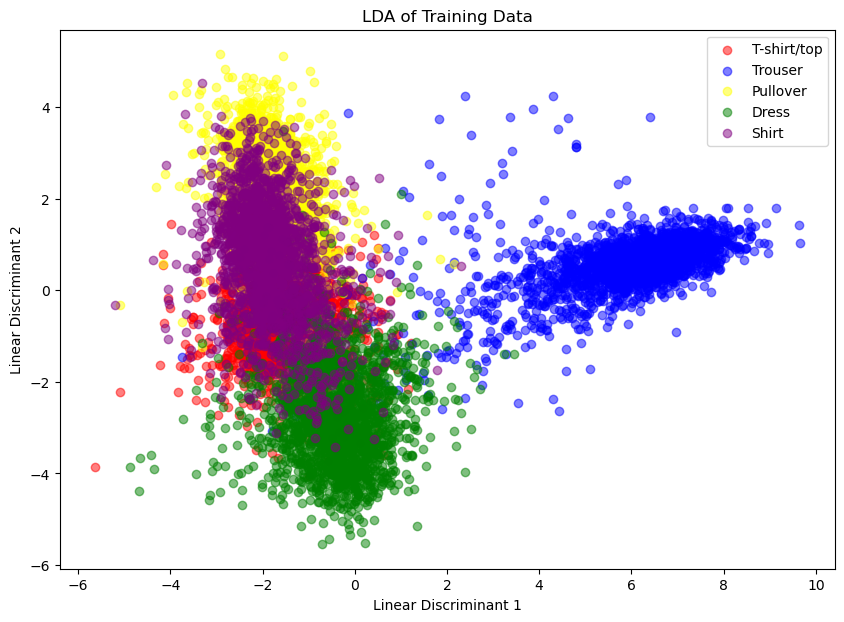

In [28]:
# Plotting the LDA results for the training data
plot_lda(train_data_lda, train_labels, 'LDA of Training Data')

Reference Decision Tree with PCA

In [29]:
# Initialize the decision tree classifier with max_depth =5 
clf = DecisionTreeClassifier(max_depth=5)

# Fit the model on the training data no need to renormalize or make a new PCA
clf.fit(train_data_pca, train_labels)

# Make predictions on the test data
test_predictions = clf.predict(test_data_pca)


In [30]:
# Calculate accuracy
accuracy_pca = np.mean(test_predictions == test_labels)
print(f"Reference Decision Tree Accuracy with PCA: {accuracy_pca * 100:.2f}%")

Reference Decision Tree Accuracy with PCA: 65.78%


In [31]:
# Generate the classification report with label names
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Shirt']
report_tree = classification_report(test_labels, test_predictions, target_names=label_names)

# Add a title to the report
print("Reference Decision Tree Trained on PCA")
print(report_tree)



Reference Decision Tree Trained on PCA
              precision    recall  f1-score   support

 T-shirt/top       0.74      0.74      0.74      1000
     Trouser       0.92      0.68      0.78      1000
    Pullover       0.61      0.83      0.70      1000
       Dress       0.61      0.83      0.70      1000
       Shirt       0.40      0.21      0.28      1000

    accuracy                           0.66      5000
   macro avg       0.65      0.66      0.64      5000
weighted avg       0.65      0.66      0.64      5000



Reference Decision Tree with LDA

In [32]:
# Initialize the decision tree classifier with the same hyperparameters
clf_lda = DecisionTreeClassifier(max_depth=5)

# Fit the model on the LDA-transformed training data
clf_lda.fit(train_data_lda, train_labels)

# Make predictions on the LDA-transformed test data
test_predictions_lda = clf_lda.predict(test_data_lda)

In [33]:
# Generate the classification report with label names
report_lda = classification_report(test_labels, test_predictions_lda, target_names=label_names)

# Add a title to the report
print("Reference Decision Tree trained on LDA")
print(report_lda)


Reference Decision Tree trained on LDA
              precision    recall  f1-score   support

 T-shirt/top       0.72      0.83      0.77      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.81      0.80      0.80      1000
       Dress       0.80      0.88      0.84      1000
       Shirt       0.71      0.55      0.62      1000

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



Functions and Classes for Hand-Coded Decision Tree

In [34]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def gini_impurity(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return 1 - np.sum(probabilities ** 2)

def information_gain(left_labels, right_labels, current_impurity):
    p = len(left_labels) / (len(left_labels) + len(right_labels))
    return current_impurity - p * gini_impurity(left_labels) - (1 - p) * gini_impurity(right_labels)

def best_split(data, labels):
    best_gain = 0
    best_split = None
    current_impurity = gini_impurity(labels)
    n_features = data.shape[1]
    
    for feature in range(n_features):
        values = np.unique(data[:, feature])
        for val in values:
            left_indices = data[:, feature] <= val
            right_indices = data[:, feature] > val
            left_labels = labels[left_indices]
            right_labels = labels[right_indices]
            
            if len(left_labels) == 0 or len(right_labels) == 0:
                continue
            
            gain = information_gain(left_labels, right_labels, current_impurity)
            
            if gain > best_gain:
                best_gain = gain
                best_split = (feature, val)
    
    return best_split

def build_tree(data, labels, depth=0, max_depth=None):
    if len(np.unique(labels)) == 1:
        return DecisionTreeNode(value=labels[0])
    
    if max_depth is not None and depth >= max_depth:
        return DecisionTreeNode(value=np.bincount(labels).argmax())
    
    feature, threshold = best_split(data, labels)
    
    if feature is None:
        return DecisionTreeNode(value=np.bincount(labels).argmax())
    
    left_indices = data[:, feature] <= threshold
    right_indices = data[:, feature] > threshold
    
    left_node = build_tree(data[left_indices], labels[left_indices], depth + 1, max_depth)
    right_node = build_tree(data[right_indices], labels[right_indices], depth + 1, max_depth)
    
    return DecisionTreeNode(feature, threshold, left_node, right_node)

def predict(tree, data_point):
    if tree.value is not None:
        return tree.value
    
    if data_point[tree.feature] <= tree.threshold:
        return predict(tree.left, data_point)
    else:
        return predict(tree.right, data_point)

def predict_batch(tree, data):
    predictions = [predict(tree, data_point) for data_point in data]
    return np.array(predictions)

Define the Decision Tree Node Class: A class DecisionTreeNode is defined to represent each node in the decision tree. Each node has attributes for the feature, threshold, left and right child nodes, and the value if it's a leaf node.

Calculate Gini Impurity: The Gini impurity is a measure of how often a randomly chosen element would be incorrectly classified. It is calculated using the formula: $$ Gini = 1 - \sum (p_i^2) $$ where 
𝑝_𝑖
 is the probability of an element belonging to class 
𝑖
.

Why Gini?

Interpretability: Gini impurity is straightforward to interpret. It measures the probability of a randomly chosen element being incorrectly classified if it was randomly labeled according to the distribution of labels in the dataset. This makes it easier to understand and explain the splits in your decision tree.

Efficiency: Calculating Gini impurity is computationally efficient. It involves simple arithmetic operations, which makes it faster to compute compared to other criteria like entropy. This can be particularly beneficial when dealing with large datasets or when building deep trees.

Performance: Gini impurity often leads to similar or even better performance compared to other criteria like entropy. It tends to create balanced splits that can improve the accuracy of the decision tree. Given your dataset's characteristics, Gini impurity can help in achieving a good balance between purity and computational efficiency.

Consistency: Gini impurity is less sensitive to small changes in the dataset compared to entropy. This can lead to more stable and consistent decision trees, which is important for reliable predictions.

Compatibility: Gini impurity works well with both categorical and continuous data. Since your dataset includes normalized and scaled features, Gini impurity can effectively handle the splits and create meaningful decision boundaries.

Why not Entropy or Misclassification Error

Entropy (Information Gain):

Complexity: Calculating entropy involves logarithmic functions, which are computationally more intensive than the arithmetic operations used in Gini impurity. This can slow down the training process, especially with large datasets.

Sensitivity to Noise: Entropy is more sensitive to small changes in the dataset compared to Gini impurity. This can lead to less stable decision trees, as small variations in the data might cause significant changes in the splits.

Overfitting: Entropy tends to create more complex trees with more splits, which can lead to overfitting. Overfitting occurs when the model captures noise in the training data rather than the underlying patterns, resulting in poor generalization to new data.

Misclassification Error:

Less Informative: Misclassification error is less sensitive to changes in the distribution of class probabilities compared to Gini impurity and entropy. This means it might not capture the nuances in the data as effectively, leading to less optimal splits.

Suboptimal Splits: Since misclassification error only considers the most frequent class, it might not provide the best splits for datasets with imbalanced class distributions or where the minority class is important.

Calculate Information Gain: Information gain measures the reduction in impurity after a dataset is split on a feature. It is calculated as: $$ Information\ Gain = Current\ Impurity - \left( \frac{n_{left}}{n_{total}} \times Gini_{left} + \frac{n_{right}}{n_{total}} \times Gini_{right} \right) $$ where 
𝑛
𝑙
𝑒
𝑓
𝑡
 and 
𝑛
𝑟
𝑖
𝑔
ℎ
𝑡
 are the number of elements in the left and right splits, respectively.

Find the Best Split: The best split is determined by iterating over all features and all possible threshold values. For each split, the information gain is calculated, and the split with the highest information gain is chosen.

Build the Tree: The decision tree is built recursively. Starting from the root node, the best split is found, and the data is divided into left and right subsets. This process is repeated for each subset until a stopping criterion is met (e.g., maximum depth or pure nodes).

Predict with the Tree: To make predictions, the data points are passed through the tree. At each node, the feature value is compared to the threshold, and the data point is directed to the left or right child node accordingly. This process continues until a leaf node is reached, and the value of the leaf node is the predicted class.

Hand-Coded Decision Tree with PCA

In [35]:
# Initiate manual decision tree with the same hyperparameters using PCA training data
decision_tree = build_tree(train_data_pca, train_labels, max_depth=5)

# Make predictions on the PCA test data
test_predictions = predict_batch(decision_tree, test_data_pca)

In [36]:
# Calculate accuracy
accuracy_pca = np.mean(test_predictions == test_labels)
print(f"Accuracy with PCA: {accuracy_pca * 100:.2f}%")

Accuracy with PCA: 65.80%


In [37]:
# Generate the classification report with label names
report = classification_report(test_labels, test_predictions, target_names=label_names)
print("Hand-Coded Decision Tree Trained on PCA")
print(report)

Hand-Coded Decision Tree Trained on PCA
              precision    recall  f1-score   support

 T-shirt/top       0.74      0.74      0.74      1000
     Trouser       0.92      0.68      0.78      1000
    Pullover       0.61      0.83      0.70      1000
       Dress       0.61      0.83      0.70      1000
       Shirt       0.40      0.21      0.28      1000

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.64      5000
weighted avg       0.66      0.66      0.64      5000



Hand-Coded Decision Tree with LDA

In [38]:
# Initiate manual decision tree with the same hyperparameters using LDA training data
decision_tree_lda = build_tree(train_data_lda, train_labels, max_depth=5)

# Make predictions on the LDA test data
test_predictions_lda = predict_batch(decision_tree_lda, test_data_lda)

In [39]:
# Calculate accuracy
accuracy_lda = np.mean(test_predictions_lda == test_labels)
print(f"Manual Decision Tree Accuracy with LDA: {accuracy_lda * 100:.2f}%")

Manual Decision Tree Accuracy with LDA: 80.36%


In [40]:
# Generate the classification report with label names
report_lda = classification_report(test_labels, test_predictions_lda, target_names=label_names)
print("Hand-Coded Decision Tree Trained on LDA")
print(report_lda)

Hand-Coded Decision Tree Trained on LDA
              precision    recall  f1-score   support

 T-shirt/top       0.72      0.83      0.77      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.81      0.80      0.80      1000
       Dress       0.80      0.88      0.84      1000
       Shirt       0.71      0.55      0.62      1000

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



Purpose
PCA: Primarily used for dimensionality reduction by transforming the data into a new coordinate system where the greatest variances by any projection of the data come to lie on the first coordinates (principal components). It aims to capture the maximum variance in the data.

LDA: Primarily used for classification by finding a linear combination of features that best separates two or more classes of objects or events. It aims to maximize the separation between different classes.

Data Transformation
PCA: Transforms the data into a new coordinate system based on the eigenvectors of the covariance matrix. The principal components are orthogonal to each other.

LDA: Transforms the data into a new space defined by the linear discriminants, which are the eigenvectors of the matrix obtained by multiplying the inverse of the within-class scatter matrix by the between-class scatter matrix.

Variance vs. Class Separation
PCA: Focuses on capturing the maximum variance in the data, regardless of the class labels. It does not consider the class labels in its computation.

LDA: Focuses on maximizing the separation between different classes by considering the class labels. It aims to find the directions that maximize the distance between the means of different classes while minimizing the spread within each class.

Number of Components
PCA: The number of principal components chosen depends on the desired level of dimensionality reduction. It can be any number up to the original number of features.

LDA: The number of linear discriminants chosen is limited to the number of classes minus one. For example, if there are three classes, LDA can have at most two linear discriminants.

Applications
PCA: Useful for tasks like data visualization, noise reduction, and feature extraction. It helps simplify complex datasets and improve the performance of machine learning algorithms by reducing the number of dimensions.

LDA: Useful for classification tasks, as it maximizes the separation between different classes. It helps improve the performance of classifiers by projecting the data onto a lower-dimensional space that best separates the classes.

The LDA models performed better than the PCA models for a few key reasons:

Class Separation: LDA is designed to maximize the separation between different classes by considering the class labels. It finds the directions that maximize the distance between the means of different classes while minimizing the spread within each class. This makes LDA particularly effective for classification tasks, as it directly optimizes for class separability.

Variance vs. Discriminative Power: PCA focuses on capturing the maximum variance in the data, regardless of the class labels. While this is useful for dimensionality reduction, it doesn't necessarily improve class separability. LDA, on the other hand, focuses on finding the directions that best separate the classes, which is more aligned with the goal of classification.

Explained Variance: In this case, the explained variance by the first four principal components in PCA was around 47.75%. This means that PCA retained only about 60.44% of the total variance in the data. In contrast, LDA explained 100.00% of the variance by the first four linear discriminants. This indicates that LDA was able to capture all the relevant information needed for classification, leading to better performance.

Dimensionality Reduction: LDA reduces the dimensionality of the data to the number of classes minus one. This ensures that the transformed data is in a lower-dimensional space that maximizes class separability. PCA, however, reduces the dimensionality based on the desired level of variance retention, which might not always align with the optimal number of dimensions for classification.